This code derived from TensorFlow Tutorials/Hvass
<br>Modified by TF to include Tensorboard logging
<br>Modified by TF to remove one FC layer
<br>Modified by TF to remove reLU
<br>Modified by TF to include dropout

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [2]:
tf.__version__


'1.0.1'

<b> Configuration of Neural Network </b>

In [3]:
#Convolution Layer 1
filter_size1 = 5 #Convolution filters are 5x5 pixels
num_filters1 = 16 #There are 16 of these filters

#Convolution Layer 2
filter_size2 = 5 #As above, 5x5 pixels
num_filters2 = 36 #there are 36 filters

#Fully-connected layer
fc_size = 128 #number of neurons in the fully connected layer

#tensorboard log directory
logs_path = "/Users/Tim/Documents/BacktoSchool/Zicklin/Handwriting/logs"



In [4]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [5]:
print("Size of:")
print("--Training set:\t\t{}".format(len(data.train.labels)))
print("--Test-set:\t\t{}".format(len(data.test.labels)))
print("--Validation-set:\t{}".format(len(data.validation.labels)))


Size of:
--Training set:		55000
--Test-set:		10000
--Validation-set:	5000


In [6]:
data.test.cls = np.argmax(data.test.labels, axis = 1)


In [7]:
#MNIST images are 28x28
img_size = 28

#Images are stored in flat arrays of this length
img_size_flat = img_size*img_size

#Tuple with height and width of images used to reshape arrays
img_shape = (img_size, img_size)

#Number of color channels for the images
num_channels = 1

#Number of classes, one for each of 10 digits
num_classes = 10

#tensorboard log directory
logs_path = "/Users/Tim/Documents/BacktoSchool/Zicklin/Handwriting/logs"


In [8]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #Create figure with 3x3 subplots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image. COME BACK TO THIS CODE TIM
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        #show true and predicted classes 
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        #show the classes as the label on the x-axis
        ax.set_xlabel(xlabel)
        
        #Remove ticks from the plot
        ax.set_xticks([])
        ax.set_yticks([])
        
    #ensure the plot is shown correctly with multiple plots in single cell
    plt.show()
    

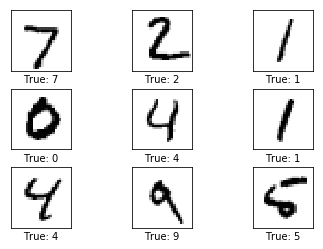

In [9]:
#Get images
images = data.test.images[0:9]

#Get the true classes
cls_true = data.test.cls[0:9]

#Plot images
plot_images(images=images, cls_true=cls_true)


In [10]:
#get all the classes in the dataset
dir(data)


['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_asdict',
 '_fields',
 '_make',
 '_replace',
 '_source',
 'count',
 'index',
 'test',
 'train',
 'validation']

In [11]:
print(data)

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x10466de80>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x104614eb8>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x10466dda0>)


<b>Function: Creating variables and initializing with random values</b>

In [12]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Create Variable Summaries for Tensorboard

In [13]:
def variable_summaries(var):
        
        #attach a  lot of summaries to a tensor for visualization. From
        #https://www.tensorflow.org/get_started/summaries_and_tensorboard
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.summary.scalar('mean', mean)
            
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))    
            tf.summary.scalar('min', tf.reduce_min(var))
            #tf.summary.historgram('histogram', var)

### Function: to create first convolution layer


In [14]:
def new_conv_layer(input, #previous layer 
                   num_input_channels,#Num. channels in prev. layer
                   filter_size,#width and size of each filter
                   num_filters, 
                   use_pooling=True,): #use 2x2 max pooling
    # adding a name scope to ensure logical grouping of layers in graph
    with tf.name_scope('Convolutional_Layer'):
        
        #shape of filter-weights for convolution. Format determined by TensorFlow API
        shape = [filter_size,filter_size,num_input_channels,num_filters]
    
        #Holds the state of the weights for the layer
        with tf.name_scope('weights'):
            #new weights aka filters with the given shape
            weights = new_weights(shape=shape)
            variable_summaries(weights)
        
        with tf.name_scope('biases'):
            #create new biases one for each filter
            biases = new_biases(length=num_filters)
            variable_summaries(biases)
    
        #TensorFlow operation for convolution. Strides are set to 1 in all dimensions. CHECK STRIDE NOTATION
        #The first and last stride must be set to 1, 
        #because the first is for the image number
        #second is for the input channel
        #e.g. [1,2,2,1] would mean that the filter moves 2 pixels across x and y axes of image
        #Padding is set to 'SAME' which means input image is padded with zeros
        #making the size of the output the same
        layer = tf.nn.conv2d(input=input, 
                         filter=weights, 
                        strides=[1,1,1,1],
                        padding='SAME')
        
        #max pool
        layer = tf.nn.max_pool(value=layer,
                            ksize=[1,2,2,1],
                            strides=[1,2,2,1],
                            padding='SAME')
        #dropout
        layer = tf.nn.dropout(layer, 0.3)
    
        #Rectified Linear Unit
        #Calculates max(x, 0) for each input pixel, x. Adds non-linearity
        #Normally ReLU executed before pooling, but since relu(max_pool(x)) == max_pool(relu(x)) 
        # we save 75% of ReLU operations by max-pooling first.
        #layer = tf.nn.relu(layer)
    
        #We use return becauase we will plot the weights later. 
        return layer, weights
    
    
    
    
    

### Function to Flatten a Layer

In [15]:
def flatten_layer(layer):
    with tf.name_scope('Flatten_Layer'):
        #Shape of input layer, assumed to be 
        #layer_shape == [num_images, img_height, img_width, num_channels]
        layer_shape=layer.get_shape()
    
        #The number of features is: img_height*img_width*num_channels]
        num_features = layer_shape[1:4].num_elements()
    
        #Reshape layer to just [num_images, num_features]
        layer_flat = tf.reshape(layer, [-1, num_features])
    
        return layer_flat, num_features
    
    
    
    
    

<b>Function to create Fully-Connected Layer</b>

In [16]:
def new_fc_layer(input, #previous layer
                num_inputs, #from previous layer
                num_outputs,
                use_relu = True, #Rectified linear unit
                use_dropout= True): #dropout
    with tf.name_scope('Fully_Connected_Layer'):
        #create new weights and biases, call previous function 
        weights = new_weights(shape=[num_inputs,num_outputs])
        biases = new_biases(length=num_outputs)
    
        #Calculate the layer as matrix multiplcation of input and weights 
        #plus the bias values
        layer=tf.matmul(input,weights) + biases
    
        #Use ReLU?
        if use_relu:
            layer = tf.nn.relu(layer)
        #Use Dropout    
        #if use_dropout:
        #    layer = tf.nn.dropout(layer, keep_prob=0.5)
        
        return layer
    

<b>Placeholder Variables</b>

In [17]:
#tensor for images, multidimensional matrix, None means the tensor holds arbitrary number of images
#with each vector of length img_size_flat representing one image.
x = tf.placeholder(tf.float32,shape=[None,img_size_flat],name='x')

with tf.name_scope('Input_Images'):
    x_image = tf.reshape(x,[-1,img_size,img_size,num_channels])

    y_true = tf.placeholder(tf.float32,shape=[None,10],name='y_true')

    y_true_cls = tf.argmax(y_true, dimension=1)

<b>Convolutional Layer 1</b>

In [18]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [19]:
layer_conv1

<tf.Tensor 'Convolutional_Layer/dropout/mul:0' shape=(?, 14, 14, 16) dtype=float32>

<b>Convolutional Layer 2</b>

In [20]:
layer_conv2, weights_conv2 =\
    new_conv_layer(input=layer_conv1,
                  num_input_channels=num_filters1,
                  filter_size=filter_size2,
                  num_filters=num_filters2,
                  use_pooling=True)
    

In [21]:
layer_conv2

<tf.Tensor 'Convolutional_Layer_1/dropout/mul:0' shape=(?, 7, 7, 36) dtype=float32>

In [22]:

weights_conv2

<b>Flatten Layer</b>

In [23]:
layer_flat, num_features = flatten_layer(layer_conv2)


In [24]:
layer_flat


<tf.Tensor 'Flatten_Layer/Reshape:0' shape=(?, 1764) dtype=float32>

In [25]:
num_features

1764

<b>Fully Connected Layer 1</b>

In [26]:
layer_fc1 = new_fc_layer(input=layer_flat,
                        num_inputs=num_features,
                        num_outputs=num_classes,
                        use_relu=False)


<b>Fully Connected Layer 2</b>

In [27]:
#layer_fc2 = new_fc_layer(input=layer_fc1, 
#                           num_inputs=fc_size,
#                        num_outputs=num_classes,
#                        use_relu=True)

In [28]:
#layer_fc2

<b>Predicted Class</b>

In [29]:
with tf.name_scope("softmax"):
    #note that here we have only used one fc layer as a predictor
    y_pred = tf.nn.softmax(layer_fc1)

In [30]:
with tf.name_scope("y_pred"):
    y_pred_cls = tf.argmax(y_pred, dimension=1)

<b>Cross-function to be optimized</b>

In [31]:
with tf.name_scope('cross_entropy'):
    #changed to fc1 layer
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc1, labels=y_true)

In [32]:
with tf.name_scope('cost'):
    cost = tf.reduce_mean(cross_entropy)

<b>Optimization Method</b>

In [33]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer().minimize(cost)

<b>Performance Measures</b>

In [34]:
with tf.name_scope('Accuracy'):
    #vector of booleans whether the predicted class equals the true class of the image
    correct_prediction = tf.equal(y_pred_cls, y_true_cls)
    #type-cast the booleans to floats (False is 0 and True is 1), then take an average
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Create cost and accuracy summaries Merge Tensorboard Summaries

In [35]:
tf.summary.scalar("cost", cost)
tf.summary.scalar("accuracy", accuracy)
summary_op = tf.summary.merge_all()


## TensorFlow Run

In [36]:
session = tf.Session()

In [37]:
#initialize variables
session.run(tf.global_variables_initializer())

#op to write logs to Tensorboard
summary_writer = tf.summary.FileWriter(logs_path,session.graph)

## Function to perform optimization iterations


In [38]:
train_batch_size = 64

In [39]:
#Counter for total iterations so far
total_iterations = 0

def optimize(num_iterations):
    #update global variable rather than local copy
    global total_iterations
    
    start_time = time.time()
    
    for i in range(total_iterations, 
                   total_iterations + num_iterations):
    
        #Get a batch of training examples
        #x_batch now holds a batch of images and 
        #y_batch are the true labels for those images
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
    
        #Put the batch into a dict with the proper names
        #for placeholder variables in the tf graph
        feed_dict_train = {x: x_batch,
                          y_true: y_true_batch}
    
        #Run the optimizer using this batch of trianing data.
        #Also runs tensors for cost and summary
        #Tf assigns the variables in feed_dict_train 
        #to the placeholder variables and then runs the optimizer
        # why does code use _ ??
        _, c, summary  =session.run([optimizer,cost,summary_op],feed_dict=feed_dict_train)
        
        #write logs at each iteration
        summary_writer.add_summary(summary, total_iterations)
        
        #print status each 100 iterations
        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
           
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            
            print(msg.format(i + 1, acc))
        
    #Update the total iteration
    total_iterations += num_iterations
    
    #total time calculation
    end_time = time.time()
       
    time_dif = end_time - start_time
    print("Time usage: "+ str(timedelta(seconds=int(round(time_dif)))))
    
    

## Function to plot example errors

In [40]:
def plot_example_errors(cls_pred, correct):
    #cls _red is an array of the predicted
    #class number for all images in the test-set
    
    #correct is a boolean array whether the predicted
    #class is equal to the true clas for each image 
    #in the test-set
    
    incorrect = (correct == False)
    
    #Get incorrectly classified imags
    images = data.test.images[incorrect]
    
    #Get the predicted classes for those images
    cls_pred = cls_pred[incorrect]
    
    #Get the true class for the incorrectly classified img
    cls_true = data.test.cls[incorrect]
    
    #Plot first 9 images
    plot_images(images=images[0:9],
               cls_true=cls_true[0:9],
               cls_pred=cls_pred[0:9])
    
    
    
    
    
    
    

## Function to plot confusion matrix

In [41]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    
    cm = confusion_matrix(y_true=cls_true,
                         y_pred=cls_pred)
    #print as text
    print(cm)
    
    #plot as image
    plt.matshow(cm)
    
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('predicted')
    plt.ylabel('true')
    
    #ensure it is plotted in one Notebook cell
    plt.show()
    

    

## Function to show performance

In [42]:
test_batch_size = 256

def print_test_accuracy(show_example_errors = False, 
                       show_confusion_matrix = False):
    num_test = len(data.test.images)
    
    #Array for the predicted class, calculated in batches and filled into this array
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    i = 0 
    
    while i < num_test:
        #The ending index for next batch is denoted by j
        j = min(i + test_batch_size, num_test)
        
        images = data.test.images[i:j, :]
        
        labels = data.test.labels[i:j, :]
        
        feed_dict = {x:images, 
                    y_true: labels}
        
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        
        i = j
    
    #true class numbers of the test set 
    cls_true = data.test.cls
    
    #Boolean array indicating correct/incorrect image classification
    correct = (cls_true == cls_pred)
    
    #Total number of correct images
    correct_sum = correct.sum()
    
    #accuracy is number of correct images over total images in test set
    acc = float(correct_sum) / num_test
    
    msg = "Accuracy on Test-Set: {0:.1%} ({1} /{2})"
    print(msg.format(acc, correct_sum, num_test))
    
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
        
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
        

In [43]:
#print_test_accuracy()

In [44]:
#optimize(num_iterations=1)

In [45]:
print_test_accuracy()

Accuracy on Test-Set: 9.2% (920 /10000)


In [46]:
#optimize(num_iterations=2)

In [47]:
#print_test_accuracy()


In [48]:
#optimize(num_iterations= 900)

## 10,000 optimizations


In [49]:
optimize(num_iterations = 1500) 

Optimization Iteration:      1, Training Accuracy:  10.9%
Optimization Iteration:    101, Training Accuracy:  82.8%
Optimization Iteration:    201, Training Accuracy:  81.2%
Optimization Iteration:    301, Training Accuracy:  81.2%
Optimization Iteration:    401, Training Accuracy:  82.8%
Optimization Iteration:    501, Training Accuracy:  84.4%
Optimization Iteration:    601, Training Accuracy:  92.2%
Optimization Iteration:    701, Training Accuracy:  87.5%
Optimization Iteration:    801, Training Accuracy:  95.3%
Optimization Iteration:    901, Training Accuracy:  93.8%
Optimization Iteration:   1001, Training Accuracy:  92.2%
Optimization Iteration:   1101, Training Accuracy:  89.1%
Optimization Iteration:   1201, Training Accuracy:  93.8%
Optimization Iteration:   1301, Training Accuracy:  95.3%
Optimization Iteration:   1401, Training Accuracy:  92.2%
Time usage: 0:03:15


Accuracy on Test-Set: 93.1% (9311 /10000)
Example errors:


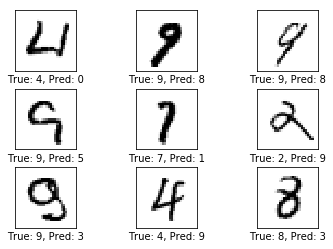

Confusion Matrix:
[[ 948    0    3    0    1    7   12    3    6    0]
 [   0 1115    3    2    2    2    1    1    9    0]
 [  11    3  940   24    7    3    4   13   24    3]
 [   0    1   12  944    0   23    1   11   14    4]
 [   2    4    3    0  922    1   12    4    6   28]
 [   2    0    2   14    2  851    3    2   12    4]
 [  15    6    2    0    8   17  907    0    3    0]
 [   0    8   25   13    6    2    0  939    2   33]
 [  15    6   13   25   12   20   10   13  847   13]
 [   9    8    1   11   29   16    0   28    9  898]]


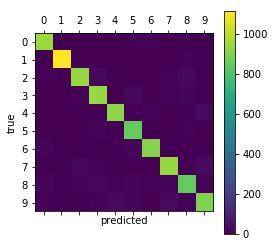

In [50]:
print_test_accuracy(show_example_errors = True, show_confusion_matrix = True)

# Visualization of Weights and Layers


In [51]:
def plot_conv_weights(weights, input_channel = 0):
    #Assume weights are TensorFlow ops for 4-dim variables, 
    #e.g. weights_conv1 or weights_conv2
    
    #Retrieve the values of the weight variables from TensorFlow. 
    #a feed-dict is not necessary b/c nothing is calculated
    w = session.run(weights)
    
    #Get extreme values. Used to correct color intensity 
    #across images so can be compared with each other
    
    w_min = np.min(w)
    w_max = np.max(w)
    
    #Number of filters used in the conv. layer
    num_filters = w.shape[3]
    
    #Number of grids to plot.
    #Rounded up sqrt of the number of filters
    num_grids = math.ceil(math.sqrt(num_filters))
    
    #Create a figure with a grid of sub-plots
    fig, axes = plt.subplots(num_grids, num_grids)
    
    #Plot all the filter-weights
    for i, ax in enumerate(axes.flat):
        #only plot the valid filter weights
        if i < num_filters:
            #Get the weights for the ith filter of the input channel
            
            #see new_conv_layer() for details on the format
            #of this 4-dim tensor
            img = w[:, :, input_channel, i]
            
            #Plot image
            ax.imshow(img, vmin = w_min, vmax = w_max, 
                     interpolation = 'nearest', cmap = 'seismic')
            
            #Remove ticks from the plot
            ax.set_xticks([])
            ax.set_yticks([])
            
    #ensure the plot is shown correctly in only one Notebook Cell
    plt.show()

## Function for plotting convolutional layer output

In [52]:
def plot_conv_layer(layer, image):
    #Assume layer is a TensorFlow op that outputs
    #a 4-dim tensor which is the output of a convo layer,
    #eg layer_con1 or layer_conv2
    

    #Create a feed dict with just one image
    #No need to feed y_true b/c not used here
    feed_dict = {x: [image]}
    
    #Calculate and retrieve the output values of the layer 
    #when inputting that image
    values = session.run(layer, feed_dict=feed_dict)
    
    num_filters = values.shape[3]
    
    #number of grids to plot, rounded up sqrt
    num_grids = math.ceil(math.sqrt(num_filters))
    
    #Create figure with grid of subplots
    fig, axes = plt.subplots(num_grids, num_grids)
    
    #figure with a grid of subplots
    for i, ax in enumerate(axes.flat):
        #only plot images for valid filters
        if i < num_filters:
            #get output image of using the ith filter
            #see new_conv_layer() for details on the format of this
            #4 dim tensor
            img = values[0, :, :, i]
            
            #plot image
            ax.imshow(img, interpolation = 'nearest', cmap = 'binary')
            
            #remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
            
    #Plot in one cell only
    plt.show()

## Function to plot an input image

In [53]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
              interpolation = 'nearest', 
              cmap = 'binary')
    
    plt.show()


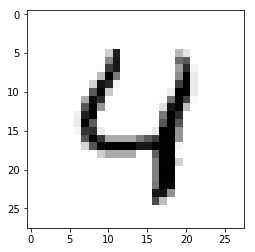

In [54]:
image1 = data.test.images[4]

plot_image(image1)

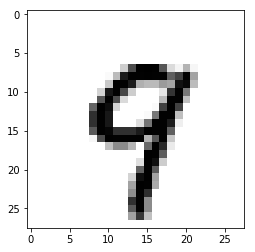

In [55]:
image2 = data.test.images[12]

plot_image(image2)

## Plot Convolutional Layer 1 

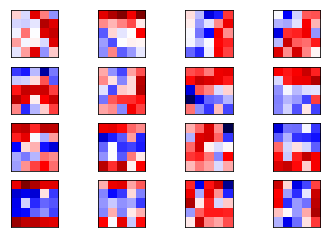

In [56]:
#positive weights are red and negative are blue
plot_conv_weights(weights = weights_conv1)

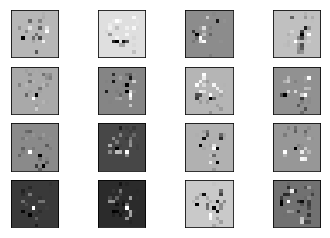

In [57]:
plot_conv_layer(layer=layer_conv1, image = image1)

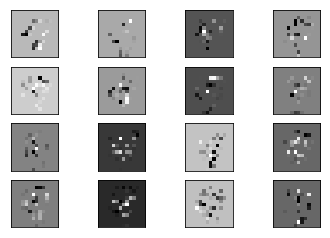

In [58]:
plot_conv_layer(layer=layer_conv1, image = image2)

## Plotting Convolutional Layer 2

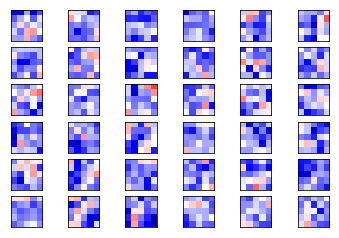

In [59]:
plot_conv_weights(weights = weights_conv2, input_channel = 0)

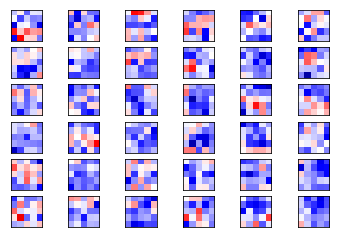

In [60]:
plot_conv_weights(weights_conv2, input_channel = 1)

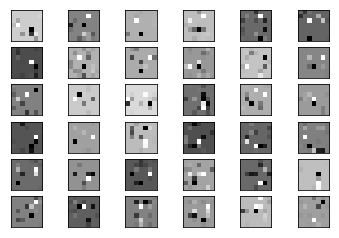

In [61]:
plot_conv_layer(layer=layer_conv2, image = image1)

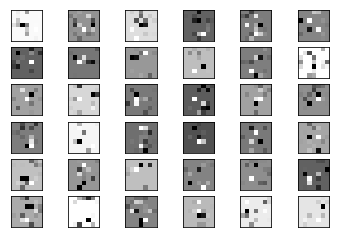

In [62]:
plot_conv_layer(layer=layer_conv2, image = image2)

In [63]:
#Optional Closing of session,
#remove # to fix the notebook.
session.close()